# Dont Run all cells the whole Notebook in the start -------

## Run from Here --------

In [1]:
import torch
import numpy as np
from glob import glob


In [2]:
files = np.array(glob("data/*/*/*"))
print('There are %d total images.' % len(files))

There are 1057 total images.


In [3]:
import os
from torchvision import datasets

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torchvision.transforms as transforms


from torch.utils.data.sampler import SubsetRandomSampler

In [4]:
num_workers = 0
batch_size = 32

transform_train = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.RandomRotation(20),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

transform_test = transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

data_dir = 'data'

#loading images in train validate and test folders into dictionary loaders_scratch with 
# train, valid, test as keys

train_data = datasets.ImageFolder(os.path.join(data_dir, 'train/'), transform=transform_train)
valid_data = datasets.ImageFolder(os.path.join(data_dir, 'valid/'), transform=transform_test)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test/'), transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)

loaders_scratch = {'train': train_loader,
                   'valid': valid_loader,
                   'test': test_loader}

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        '''using stride 2 in place of maxpooling layers'''
        
        # in : 3*224*224
        self.conv1 = nn.Conv2d(3, 16, 4, stride = 2, padding = 1)
        
        # in :16* 112 *112
        self.conv2 = nn.Conv2d(16, 32, 4, stride = 2, padding = 1)
        
        # in : 32 * 56 * 56
        self.conv3 = nn.Conv2d(32, 64, 4, stride = 2, padding = 1)
        # out : 64*28*28
        
        #self.conv4 = nn.Conv2d(64, 128, 4, padding = 1)
        
        self.fc1 = nn.Linear(64*7*7, 784)
        self.fc2 = nn.Linear(784, 7)
        
        self.dropout = nn.Dropout(p = 0.2)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        ## Define forward behavior
        
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.batch_norm1(self.conv2(x)), 0.2)
        x = self.maxpool(x)
        x = F.leaky_relu(self.batch_norm2(self.conv3(x)), 0.2)
        x = self.maxpool(x)
        #x = F.leaky_relu(self.conv4(x), 0.2)
        #x = self.maxpool(x)
        
        x = x.view(-1, 64*7*7)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        # No relu here, we use CELoss
        x = self.fc2(x)
        
        
        
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

In [6]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.1)

In [7]:
def train(n_epochs, loaders, model, optimizer, criterion, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            optimizer.zero_grad()
            
            #typical train step:
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            ## update the average validation loss
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
            
    # return trained model
    return model

# Dont Change this -------------------------
This is the training cell --------

In [74]:
#model_scratch = train(40, loaders_scratch, model_scratch, optimizer_scratch, 
                      #criterion_scratch, 'model_scratch1.pt')

Epoch: 1 	Training Loss: 1.552730 	Validation Loss: 1.184297
Validation loss decreased (inf --> 1.184297).  Saving model ...
Epoch: 2 	Training Loss: 1.039115 	Validation Loss: 0.506868
Validation loss decreased (1.184297 --> 0.506868).  Saving model ...
Epoch: 3 	Training Loss: 0.767379 	Validation Loss: 0.617828
Epoch: 4 	Training Loss: 0.725829 	Validation Loss: 0.475614
Validation loss decreased (0.506868 --> 0.475614).  Saving model ...
Epoch: 5 	Training Loss: 0.677602 	Validation Loss: 0.521023
Epoch: 6 	Training Loss: 0.518473 	Validation Loss: 0.625444
Epoch: 7 	Training Loss: 0.532496 	Validation Loss: 0.425283
Validation loss decreased (0.475614 --> 0.425283).  Saving model ...
Epoch: 8 	Training Loss: 0.497061 	Validation Loss: 0.799509
Epoch: 9 	Training Loss: 0.488972 	Validation Loss: 0.853165
Epoch: 10 	Training Loss: 0.395300 	Validation Loss: 0.194511
Validation loss decreased (0.425283 --> 0.194511).  Saving model ...
Epoch: 11 	Training Loss: 0.506461 	Validation Lo

# Run From HERE to see your test results ------- 


In [8]:
import matplotlib.pyplot as plt                        
%matplotlib inline                               


In [9]:
class_names = [item[:].replace("_", " ") for item in loaders_scratch['test'].dataset.classes]

def predict_photo_scratch(img_path):
    # load the image and return the predicted breed
    
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([transforms.Resize(size=224),
                                    transforms.CenterCrop((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
    
    img = transform(img).unsqueeze(0)
    
    out = model_scratch(img)
    
    _, prediction = torch.max(out, 1)
    
    pred = np.squeeze(prediction.cpu().numpy())
    
    
    return class_names[pred]

In [10]:
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    photo = predict_photo_scratch(img_path)
    if(photo == "apple" or photo == "orange" or photo == "banana" or photo == "mixed"):
        print("Organic")
    else:
        print("Recyclable")
    image = Image.open(img_path)
    plt.imshow(image)
    plt.show()
    print("This is...... {}".format(photo))
    print()
    print()

# Dont run this cell ----- 
This is our testing results ------

Test Loss: 1.097745


Test Accuracy: 79% (162/204)
Organic


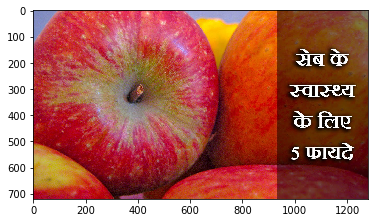

This is...... apple


Organic


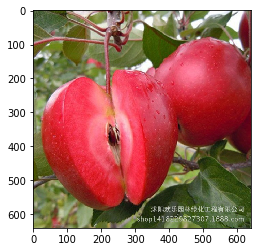

This is...... apple


Organic


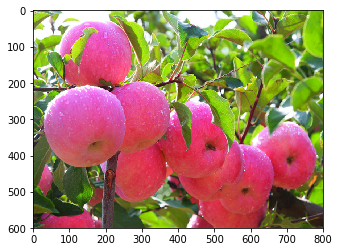

This is...... apple


Organic


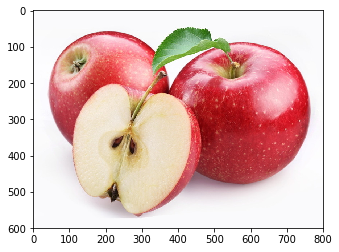

This is...... apple


Organic


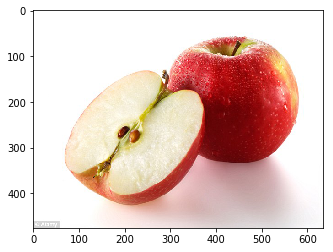

This is...... apple


Organic


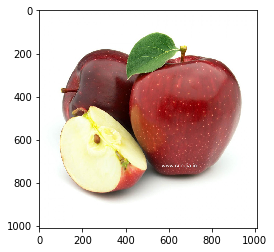

This is...... apple


Organic


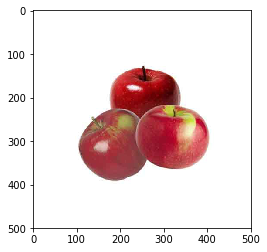

This is...... apple


Organic


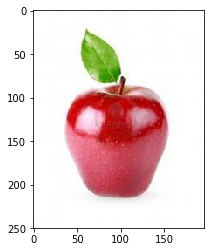

This is...... apple


Organic


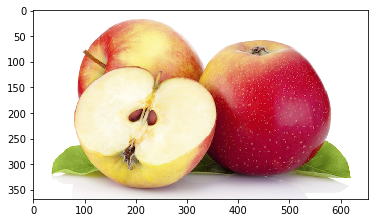

This is...... apple


Organic


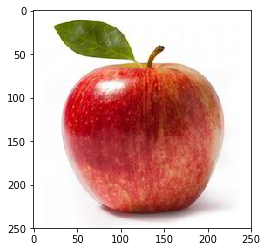

This is...... apple




In [20]:
model_scratch.load_state_dict(torch.load('model_scratch1.pt'))
def test(loaders, model, criterion):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
    for file in np.hstack((files[0:10])):
        run_app(file)

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch)

### Into the data/test folder add your testing images
Then run the below cell to see the output for your testing images

In [ ]:
model_scratch.load_state_dict(torch.load('model_scratch1.pt'))
def test(loaders, model, criterion):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
    for file in np.hstack((files)):
        run_app(file)

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch)